# Prompt

First, you learned about the importance of transforming your data into a stationary series. You tested for stationarity using the adfuller function and interpreted the value of the hypothesis test. If the data was not stationary, you learned how to apply strategies, such as differencing and logarithmic transformations, to achieve stationarity.

Once the series was stationary, building an ARMA model involved using autocorrelation and partial autocorrelation plots to determine the appropriate p and q parameters of the model.

This activity asks you to identify a time series of interest to you and build an ARMA model to construct a basic forecast for the series and analyze the error. You might also consider building models with different p and q parameters because, while ACF and PACF plots are helpful, they provide rough ideas of the appropriate parameters, and it is usually good practice to perform a simple grid search on these. 

Please find a time series dataset using any resource you would like, and present your model and findings to the class.  

If you have trouble locating a dataset or would prefer a suggestion, try the [Rossmann Store Sales](https://www.kaggle.com/c/rossmann-store-sales) from Kaggle. This dataset involves forecasting retail store sales for a major drug store.

# Imports

In [1]:
import warnings
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose, _extrapolate_trend
from statsmodels.tsa.filters.filtertools import convolution_filter
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast

from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [2]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
mpl.rcParams.update({"axes.grid": True})

# Data Load

Looking at snowfall per month for Mammoth Mountain, from 1969 to the present, as obtained from  
- https://www.mammothmountain.com/on-the-mountain/snowfall-history

See [pre-processing notebook](./mammoth_snowfall_datagen.ipynb) for how I generated this table from the Mammoth website data

In [3]:
df = pd.read_csv("./data/mammoth_mountain_snowfall_melted_table.csv")
df.head()

,Date,Month,Snow Fall
0,1970-01-01,Jan,78.0
1,1970-02-01,Feb,30.5
2,1970-03-01,Mar,46.0
3,1970-04-01,Apr,27.0
4,1970-05-01,May,0.0


In [4]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date")
df.head()

,Month,Snow Fall
Date,,
1970-01-01,Jan,78.0
1970-02-01,Feb,30.5
1970-03-01,Mar,46.0
1970-04-01,Apr,27.0
1970-05-01,May,0.0


In [5]:
monthly_average = df.groupby("Month")[["Snow Fall"]].agg(np.mean)
monthly_average.rename({"Snow Fall": "Monthly Average"}, inplace=True)
monthly_average["Month"] = monthly_average.index
monthly_average = monthly_average.reset_index(drop=True)
monthly_average

,Snow Fall,Month
0,32.924074,Apr
1,2.870370,Aug
2,66.411111,Dec
3,69.761111,Feb
4,71.333333,Jan
5,0.000000,Jul
6,0.190741,Jun
7,63.718519,Mar
8,8.029630,May
9,29.162963,Nov


In [6]:
df.insert(loc=0, column="Monthly Average", value=df["Snow Fall"] * 0)

In [7]:
for k in range(len(df)):
    this_row = df.iloc[k, :]
    this_month = this_row[1]
    df["Monthly Average"].iloc[k] = monthly_average[
        monthly_average["Month"] == this_month
    ]["Snow Fall"]

In [8]:
df.head(15)

,Monthly Average,Month,Snow Fall
Date,,,
1970-01-01,71.333333,Jan,78.0
1970-02-01,69.761111,Feb,30.5
1970-03-01,63.718519,Mar,46.0
1970-04-01,32.924074,Apr,27.0
1970-05-01,8.029630,May,0.0
1970-06-01,0.190741,Jun,0.0
1970-07-01,0.000000,Jul,0.0
1970-08-01,2.870370,Aug,30.0
1970-09-01,2.870370,Sep,30.0


# All Data

## Plot

In [9]:
y_all = df["Snow Fall"]

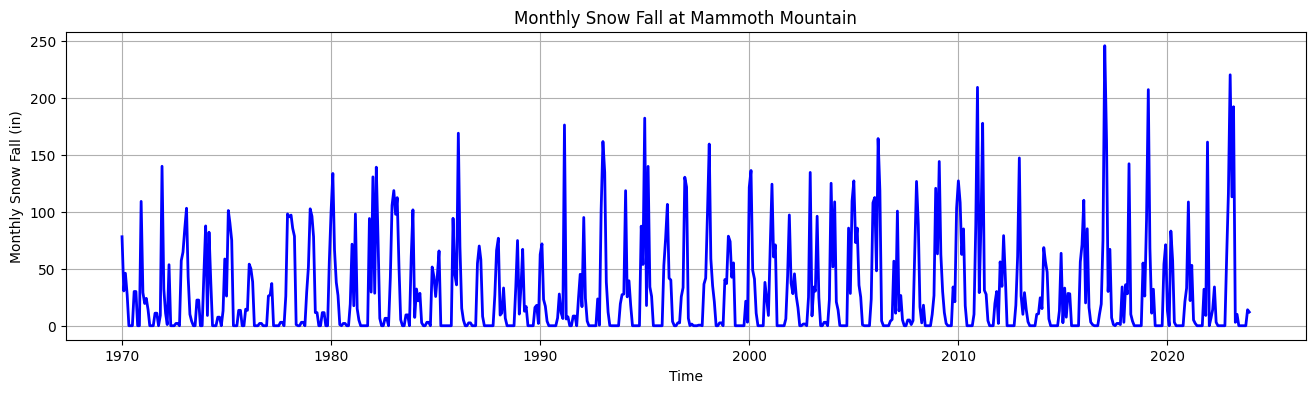

In [10]:
plt.figure(figsize=(16, 4))
plt.plot(y_all, color="blue", lw=2)
plt.title("Monthly Snow Fall at Mammoth Mountain")
plt.xlabel("Time")
plt.ylabel("Monthly Snow Fall (in)")
plt.show()

## Not Stationary

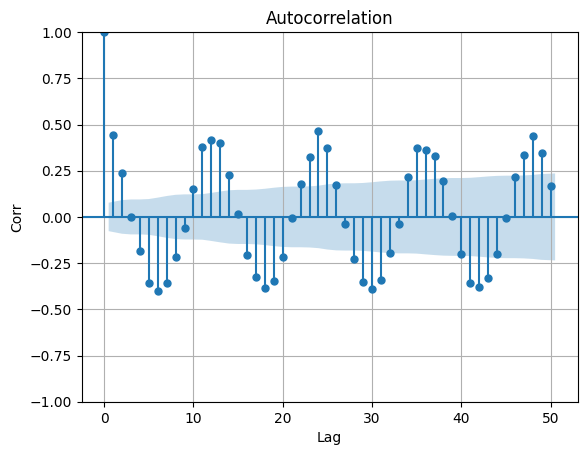

In [11]:
plot_acf(y_all, lags=50)
plt.xlabel("Lag")
plt.ylabel("Corr")
plt.show()

In [12]:
display(adfuller(y_all))

(-5.990432788444341,
 1.7509203967575674e-07,
 16,
 631,
 {'1%': -3.440755866431696,
  '5%': -2.86613130039063,
  '10%': -2.569215089800357},
 6212.114682164603)

# First Difference

## Plot

In [13]:
y_diff = df["Snow Fall"].diff().dropna()

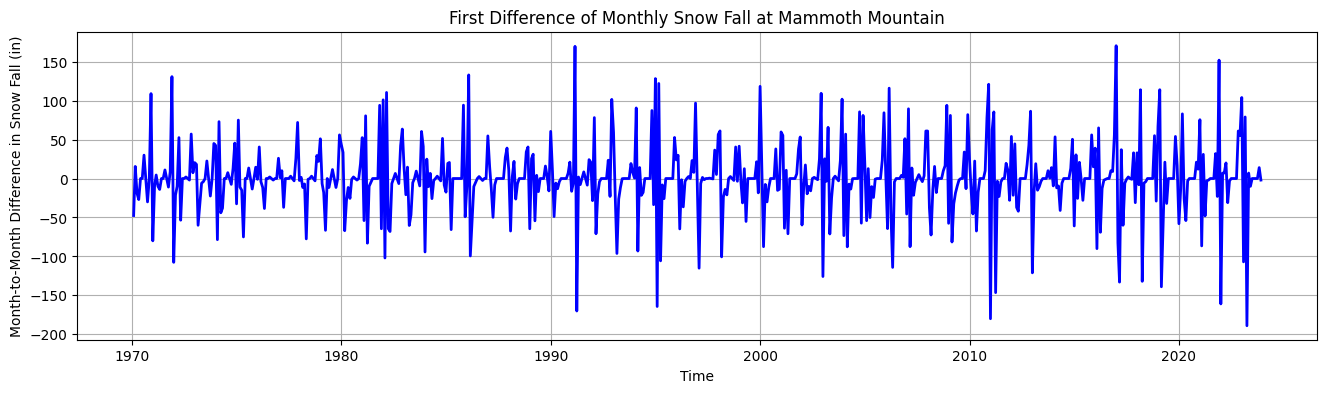

In [14]:
plt.figure(figsize=(16, 4))
plt.plot(y_diff, color="blue", lw=2)
plt.title("First Difference of Monthly Snow Fall at Mammoth Mountain")
plt.xlabel("Time")
plt.ylabel("Month-to-Month Difference in Snow Fall (in)")
# plt.legend(loc="upper left")
plt.show()

## Somewhat Stationary

In [15]:
def plot_acf_pacf(y):
    (fig, ax) = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
    plot_acf(y, lags=10, ax=ax[0])
    ax[0].set_title("ACF - MA(q)")
    ax[0].set_xlabel("Lag")
    ax[0].set_ylabel("Corr")

    plot_pacf(y, lags=10, ax=ax[1])
    ax[1].set_title("PACF - AR(p)")
    ax[1].set_xlabel("Lag")
    ax[1].set_ylabel("Corr")
    plt.show()

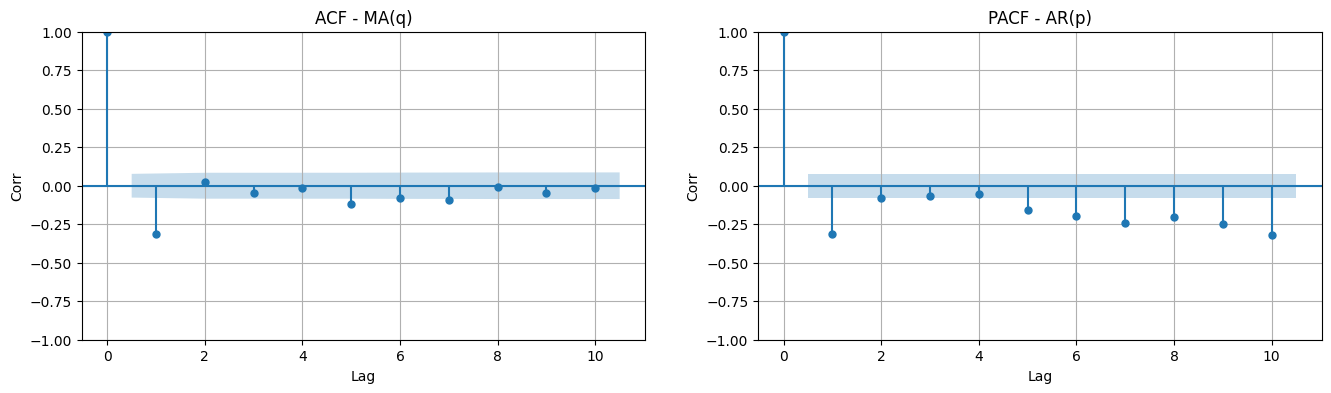

In [16]:
plot_acf_pacf(y_diff)

In [17]:
display(adfuller(y_diff))

(-9.586847104753582,
 2.0861995790215733e-16,
 20,
 626,
 {'1%': -3.4408393249134326,
  '5%': -2.86616806030903,
  '10%': -2.569234676071002},
 6227.474175331561)

# Second Difference

In [18]:
y_diff2 = y_diff.diff().dropna()

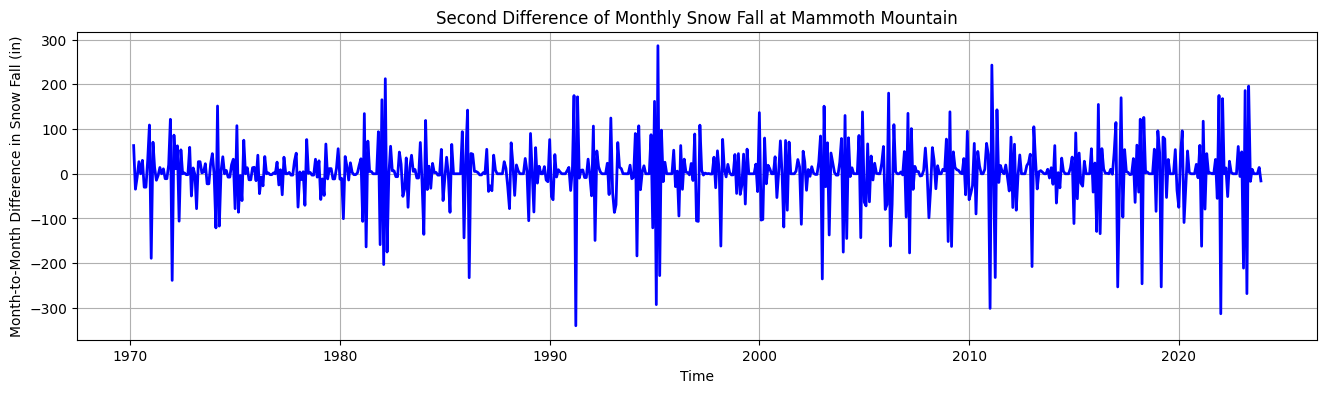

In [19]:
plt.figure(figsize=(16, 4))
plt.plot(y_diff2, color="blue", lw=2)
plt.title("Second Difference of Monthly Snow Fall at Mammoth Mountain")
plt.xlabel("Time")
plt.ylabel("Month-to-Month Difference in Snow Fall (in)")
# plt.legend(loc="upper left")
plt.show()

## More Stationary - Use AR(p=4) and MA(q=1)

So choose to model 2nd difference

AR(p)
- PACF
- p = 4  

MA(q)
- ACF
- q = 1  

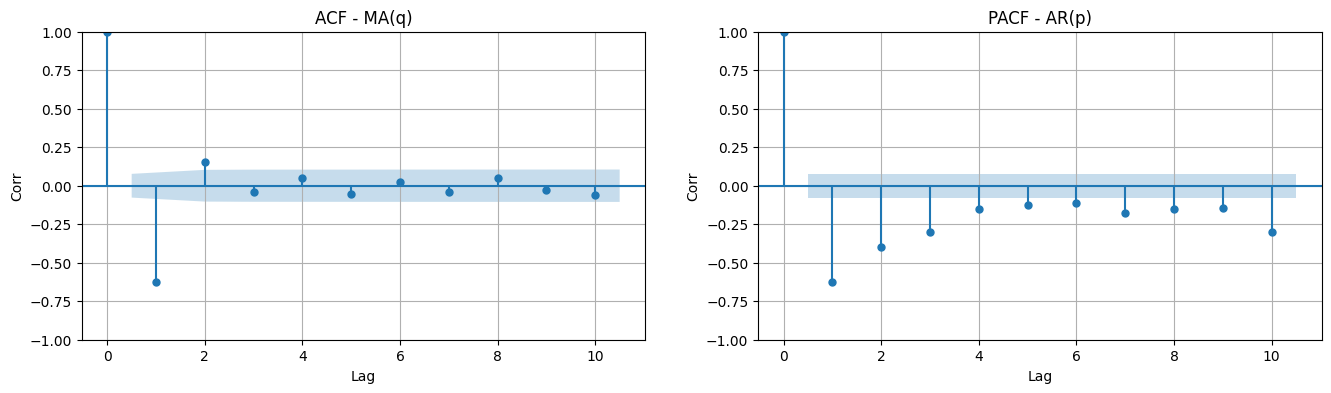

In [21]:
plot_acf_pacf(y_diff2)

In [22]:
display(adfuller(y_diff2))

(-15.611548807116153,
 1.7772326936168353e-28,
 16,
 629,
 {'1%': -3.4407890899441127,
  '5%': -2.8661459340578905,
  '10%': -2.5692228868342766},
 6301.033767585585)

# Train / Test Split on y_diff2

In [23]:
y_target = y_diff2
y_exog = df["Monthly Average"].head(len(y_target))
y_exog.index = y_target.index

In [24]:
n_steps_future = 16
(y_history, y_future, y_exog_history, y_exog_future) = train_test_split(
    y_target, y_exog, shuffle=False, test_size=n_steps_future
)

In [25]:
# (y_exog, y_exog_history, y_exog_future) = (None, None, None)

# Fit with ARIMA

In [26]:
p_list = range(1, 3)
d_list = range(2)
q_list = range(1, 3)
mae_fit_list = []
rmse_fit_list = []
best = np.Inf

seasonal_order = (0, 0, 0, 0)

if 0:
    for p in p_list:
        for q in q_list:
            for d in d_list:
                order_p_d_q = (p, d, q)
                estimator = ARIMA(
                    y_history,
                    order=order_p_d_q,
                    seasonal_order=seasonal_order,
                    exog=y_exog_history,
                ).fit()

                y_fit = estimator.predict()
                y_forecast = estimator.forecast(
                    steps=n_steps_future, exog=y_exog_future
                )
                mae_fit = mean_absolute_error(y_history, y_fit)
                rmse_fit = root_mean_squared_error(y_history, y_fit)
                mae_forecast = mean_absolute_error(y_future, y_forecast)
                rmse_forecast = root_mean_squared_error(y_future, y_forecast)

                if mae_forecast < best:
                    best = mae_fit
                    print(
                        "order_p_d_q = (%d, %d, %d), MAE = (%.2f, %.2f), RMSE = (%.2f, %.2f)"
                        % (p, d, q, mae_fit, mae_forecast, rmse_fit, rmse_forecast)
                    )

In [27]:
order_p_d_q = (2, 1, 2)
estimator = ARIMA(y_history, order=order_p_d_q, exog=y_exog_history).fit()
# display(estimator.summary())

In [28]:
y_fit = estimator.predict()
y_forecast = estimator.forecast(steps=n_steps_future, exog=y_exog_future)
y_hat = estimator.predict(
    start=y_target.index[0], end=y_target.index[-1], exog=y_exog_future
)

In [29]:
# pd.DataFrame({"y-forecast": y_forecast, "y-hat-tail": y_hat.tail(n_steps_future)})

In [30]:
mae_fit = mean_absolute_error(y_history, y_fit)
rmse_fit = root_mean_squared_error(y_history, y_fit)
mae_forecast = mean_absolute_error(y_future, y_forecast)
rmse_forecast = root_mean_squared_error(y_future, y_forecast)
[mae_fit, rmse_fit, mae_forecast, rmse_forecast]

[27.46891100491043, 38.47427809266424, 66.5516812051385, 110.27305281925616]

## Plot Data and Fit

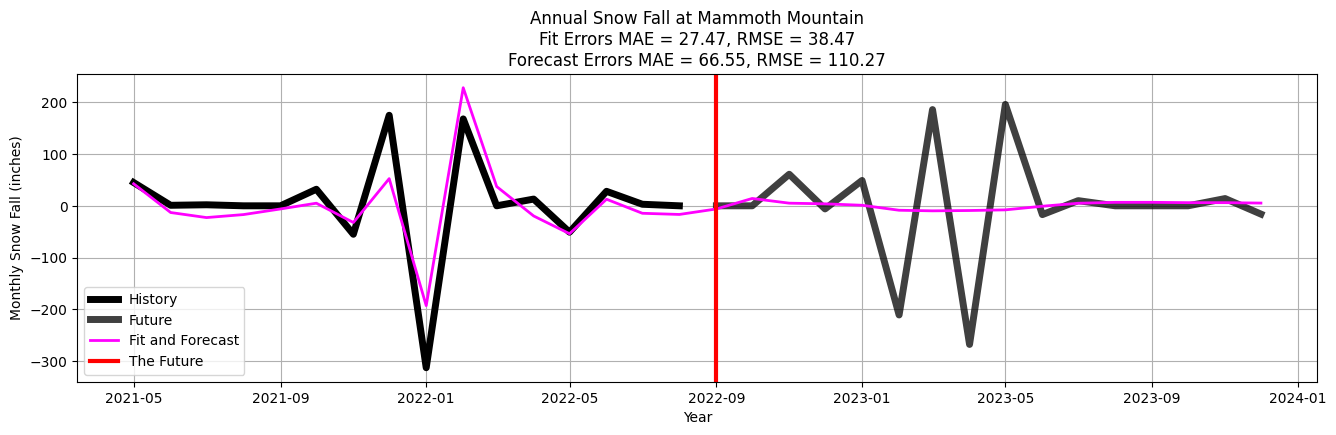

In [37]:
nplot = n_steps_future
plt.figure(figsize=(16, 4))
plt.plot(y_history.tail(nplot), color="black", label="History", lw=5)
plt.plot(y_future, color="black", alpha=0.75, label="Future", lw=5)
plt.plot(
    y_hat.tail(nplot + n_steps_future), color="magenta", label="Fit and Forecast", lw=2
)
plt.axvline(y_future.index[0], color="red", label="The Future", lw=3)
plt.title(
    "Annual Snow Fall at Mammoth Mountain\nFit Errors MAE = %.2f, RMSE = %.2f\nForecast Errors MAE = %.2f, RMSE = %.2f"
    % (mae_fit, rmse_fit, mae_forecast, rmse_forecast)
)
plt.xlabel("Year")
plt.ylabel("Monthly Snow Fall (inches)")
plt.legend(loc="lower left")
plt.show()

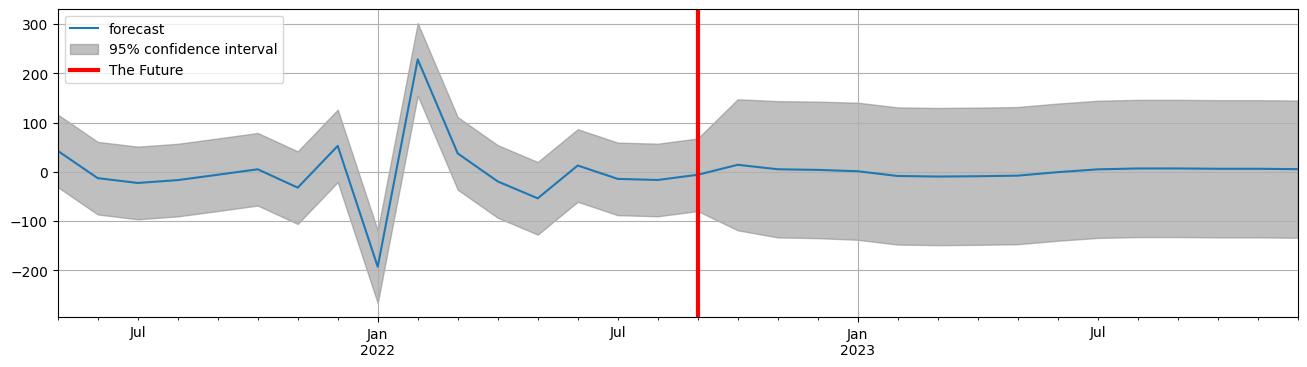

In [39]:
fig, ax = plt.subplots(figsize=(16, 4))
fig = plot_predict(
    estimator, start=y_history.tail(n_steps_future).index[0], end=y_future.index[-1], ax=ax, exog=y_exog_future
)
plt.axvline(y_future.index[0], color="red", label="The Future", lw=3)
legend = ax.legend(loc="upper left")
plt.show()

## Plot Residue

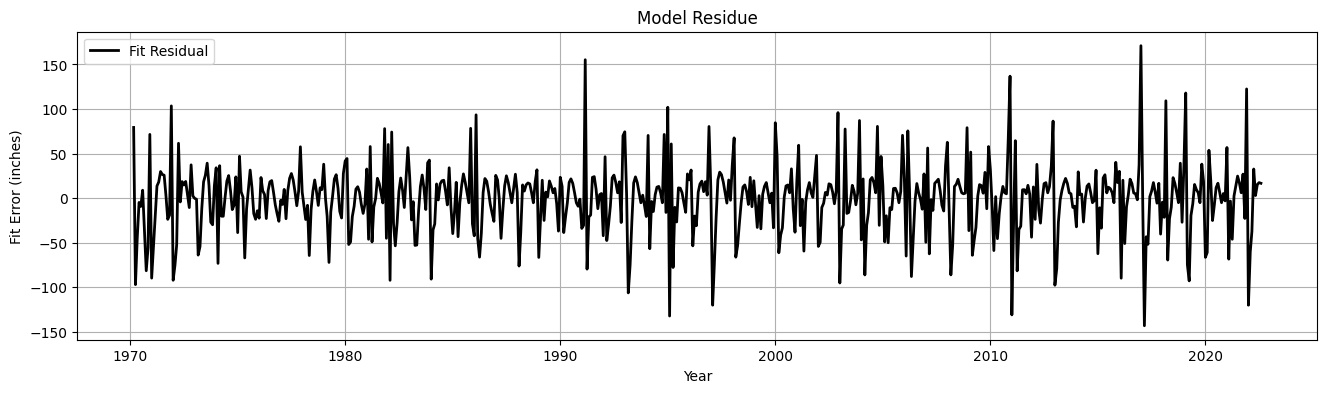

In [33]:
plt.figure(figsize=(16, 4))
plt.plot(estimator.resid, color="black", lw=2, label="Fit Residual")
plt.title("Model Residue")
plt.xlabel("Year")
plt.ylabel("Fit Error (inches)")
plt.legend(loc="upper left")
plt.show()

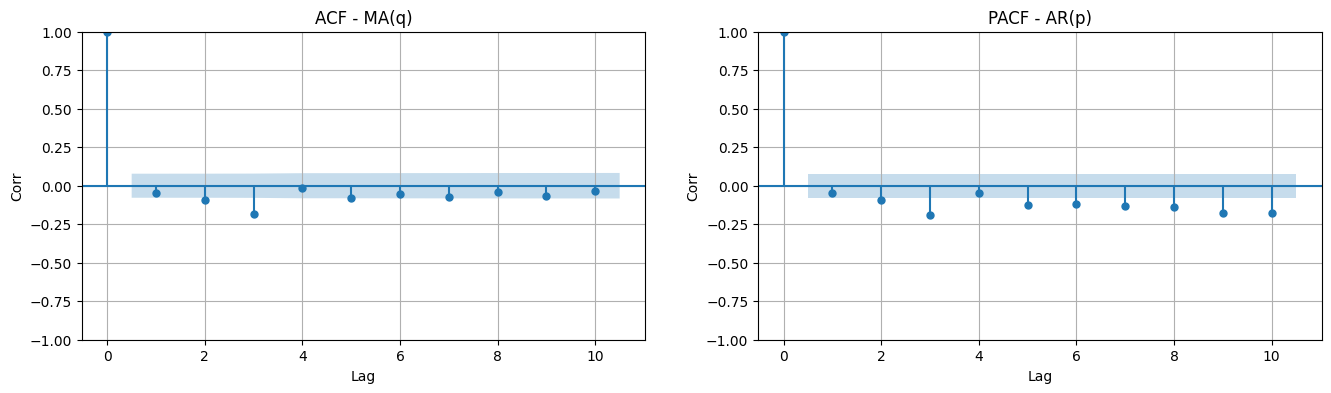

In [34]:
plot_acf_pacf(estimator.resid)

In [35]:
display(adfuller(estimator.resid))

(-13.771714706684287,
 9.654883094633568e-26,
 11,
 618,
 {'1%': -3.440975679277454,
  '5%': -2.8662281164567927,
  '10%': -2.5692666752547626},
 6016.827713681904)